# <b style="color: #151151">Lab 2 - Arend Wong (aw3146) - 2021-05-21<b>

<i style='color: blue;'>
Due Monday by 11:59pm Points 100 Submitting a website url or a file upload
Lab #2

1. Recode 2 different variables into new categories. They can both be continuous-ish or both be nominal-ish, or one of each. Tell me what you did and explain the variable(s).

2. Use one (or both) of your recoded variables to do a cross-tabulation. Explain your results.

3. Run a linear regression with 1 independent and 1 dependent variable; make all of the recodes necessary to make the model as easy to interpret as possible; and explain your results.

4. Plot two variables, either as a scatter plot or boxplot; add in trend/regression lines; and explain your results.
</i>


## Setup & module imports...

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import re, os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns #os.system('pip install seaborn')
from scipy import stats
import pycountry_convert as pc #os.system("pip install pycountry-convert")
from colour import Color #os.system('pip install colour')

def printurn(x):
    print(x)
    return(x)

def recode_onehot_if(s='CHILDRENS COAT', pattern='CHILDREN'):
    result = '1' if pattern in str(s) else '0'
    return(result)

def check_color(color):
    try:
        Color(color)
        return(True)
    except ValueError as e:
        return(False)

def extract_color(pdcolumn):
    pdcolumn = pd.Series(pdcolumn.copy()) if type(pdcolumn)==str else pd.Series(pdcolumn) if type(pdcolumn)==list else pdcolumn
    newcolumn = pdcolumn.copy().apply(lambda s: ' '.join([i for i in str(s).split(' ') if check_color(i)]))
    return(newcolumn)

def compute_percentage(x, my_crosstab):
      pct = float(x/my_crosstab['count'].sum()) * 100
      return round(pct, 2)

os.listdir('../lab1')

['.ipynb_checkpoints',
 'courseworks',
 'data.csv',
 'lab 1 updated.html',
 'lab1.ipynb',
 'lab1.py']

## Dataset choses & read as a dataframe object:
##### Read raw CSV URL of dataset into a dataframe...!
###### OR
##### Read CSV in local disk/repo from file path! 

## Description of dataset chosen:
### Reading data below! We're using our own custom dataset (not the GSS data!). I found this sample retail sales dataset at this link: #https://www.kaggle.com/carrie1/ecommerce-data. I'm using this dataset because it aligns with my personal research interests and I wanted to make this lab as utilitarian as possible! It's data from a UK-based retailer. Each observation (row) of the data corresponds to one sale. The data has price of item, quantity sold in each individual purchase transaction, country of sale, and description of item. I'm focusing on the description of the items and recoding that text variable into more useful categorical variables (explained below).

In [116]:
USE_POCKETS_DATA = False
if USE_POCKETS_DATA:
    url = "https://raw.githubusercontent.com/the-pudding/data/master/pockets/measurements.csv"
    df = pd.read_csv(url) # https://github.com/the-pudding/data/blob/master/pockets/measurements.csv
    df
else:
    try: # NOTE: trying to read the csv file with basic default args first, but if error, we're adding the encoding argument. Since this dataset has text data, the encoding has some quirks and some Python & Pandas versions don't support it with default UTF-8 encoding.
        df = pd.read_csv('../lab1/data.csv').drop_duplicates().query('Quantity>=0 and Quantity<=70000 and UnitPrice>=0').reset_index(drop=True) # dataset is from #https://www.kaggle.com/carrie1/ecommerce-data
    except:
        df = pd.read_csv('../lab1/data.csv', encoding="ISO-8859-1").drop_duplicates().query('Quantity>=0 and Quantity<=70000 and UnitPrice>=0').reset_index(drop=True) #https://www.kaggle.com/carrie1/ecommerce-data 
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
526045,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
526046,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
526047,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
526048,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# <hr></hr>

# <b style="color: darkblue">1. Recode 2 different variables into new categories. They can both be continuous-ish or both be nominal-ish, or one of each. Tell me what you did and explain the variable(s).</b>
## - <code>invoice_month</code> and <code>n_words_description</code>

### <code>invoice_month</code>: nominal-ish.
#### I'm creating a new variable called invoice_month from the invoice_date. I'm extracting just the month from the whole date codes in the InvoiceDate variable. It's nominal-ish because each class theoretically belongs to a consecutive month category, ie: January=1, Feb=2, Mar=3, Apr=4, ..., Nov=11, Dec=12. This variable will let us examine trends as the year progresses, but it's making the analysis simpler for us because it's ideologically binning continuous time into nominal months.

### <code>n_words_description</code>: continuous.
#### I'm creating a new variable called n_words_description from the Description columns (description of each retail item). I'm extracting just the number of words in the description. I'm wondering if longer/more verbose descriptions may be associated with any sales trends. By extracting the number of words in each description, we have a simple but useful heuristic for verbosity of item-description.


### - Additional recoding (not totally relevant to the Qs in the lab): - <code>material</code> and <code>continent</code>

#### I'm recoding some variables/creating new ones below! I'm also filtering the data so that it only has the observations we care about (valid UnitPrices and valid Quantity sold for each given transation). My new  <code>material</code> categorical variable is derived from the Description column. I pulled out possible materials from the descriptions of the items sold. I'll summarize them below.
##### I'm recoding a new variable called <code>continent</code> from the current Country variable. This will help us get a narrowed down data set of georaphies so as to really analyze the material purchased based off geographical region. I'm recoding the country variable as a new variable (continent for example) by using a python package called pycountry_convert and looping through each class in our Country variable.

##### For curiority's sake, I created a few other categorical variables from the description column too (but I won't focus on them for this lab). I extracted item color, base item object, and whether the items is meant for children or not. All of these derived variables are first-drafts just for identifying initial patterns in the data. They're not perfect, but they're helpful for this exercise!

In [117]:
if USE_POCKETS_DATA:
    # Create 3 new columns for PRIMARY material, etc...
    df_new = df.copy().assign(
            primary_fabric = df.fabric.apply(lambda s: s.split(', ')[0]),
            primary_fabric_pct = df.fabric.apply(lambda s: s.split(' ')[0].replace('%','')).astype(float).div(100),
            primary_fabric_name = df.fabric.apply(lambda s: s.split(' ')[1].replace(',', ''))
            ).apply(lambda y: y.str.lower().str.strip().replace({'cottton':'cotton'}, regex=True) if str(y.dtype)=='object' else y)
    df_new = df_new[df_new.columns[df_new.columns.str.contains('maxHeightBack|minHeightBack|brand|style|men|name|fabric|price|cut|var|val|maxheightback|minheightback')]]
    print('df_new.shape # (80, 19)', df_new.shape) # (80, 19)
else:
    df_new = df.copy().apply(lambda y: y.str.lower() if str(y.dtype)=='object' else y).assign(
        #children=lambda d: [recode_onehot_if(x, 'children') for x in d.Description],
        purchase_price = lambda d: d.UnitPrice * d.Quantity,
        invoice_month = lambda d: pd.DatetimeIndex(d.InvoiceDate).month,
        invoice_year = lambda d: pd.DatetimeIndex(d.InvoiceDate).year,
        invoice_day_of_month = lambda d: pd.DatetimeIndex(d.InvoiceDate).day,
        n_words_description = lambda d: [len(str(x).split()) for x in d.Description],
        #noun=lambda d: [str(x).split()[-1].strip() for x in d.Description],
        material=lambda d: d.Description.str.extract(r'(ceramic|metal|wood|plastic|cloth|felt|fabric|silk|polyester|linen|cotton|compostable|mahogany|canvas|cashmere|chiffon|denim|viscose|wool|fur|lace|leather|diamond|crystal|rhinestone|jewel|birch|rubber|wax|vintage|organic|pashmina|satin|spandex|suede|cement|marble)', expand=False, flags=re.IGNORECASE),
        color=lambda d: extract_color(d.Description).apply(lambda s: s.split(' ')[0]),
        ).apply(lambda y: y.str.lower().str.strip().replace('', np.nan) if str(y.dtype)=='object' else y)
    print('df_new.shape # (531283, 11)', df_new.shape) # (531283, 11))
    new_list = []
    for boob in df_new.Country.str.title():
        try:
            new_boob = pc.country_name_to_country_alpha2(boob, cn_name_format="default")
            new_boob = pc.country_alpha2_to_continent_code(new_boob)
        except:
            new_boob = ''
        new_list.append(new_boob)
    df_new['continent'] = new_list
df_new

df_new.shape # (531283, 11) (526050, 15)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,purchase_price,invoice_month,invoice_year,invoice_day_of_month,n_words_description,material,color,continent
0,536365,85123a,white hanging heart t-light holder,6,12/1/2010 8:26,2.55,17850.0,united kingdom,15.30,12,2010,1,5,NaN,white,EU
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850.0,united kingdom,20.34,12,2010,1,3,metal,white,EU
2,536365,84406b,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850.0,united kingdom,22.00,12,2010,1,5,NaN,NaN,EU
3,536365,84029g,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850.0,united kingdom,20.34,12,2010,1,6,NaN,NaN,EU
4,536365,84029e,red woolly hottie white heart.,6,12/1/2010 8:26,3.39,17850.0,united kingdom,20.34,12,2010,1,5,wool,red,EU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526045,581587,22613,pack of 20 spaceboy napkins,12,12/9/2011 12:50,0.85,12680.0,france,10.20,12,2011,9,5,NaN,NaN,EU
526046,581587,22899,children's apron dolly girl,6,12/9/2011 12:50,2.10,12680.0,france,12.60,12,2011,9,4,NaN,NaN,EU
526047,581587,23254,childrens cutlery dolly girl,4,12/9/2011 12:50,4.15,12680.0,france,16.60,12,2011,9,4,NaN,NaN,EU
526048,581587,23255,childrens cutlery circus parade,4,12/9/2011 12:50,4.15,12680.0,france,16.60,12,2011,9,4,NaN,NaN,EU


### Visualizing value counts & other descriptive statistics for the factors of our variable(s) of interest

In [118]:
df_new0 = df_new.copy()
print("Our dataframe's columns:", df_new.columns)
print(df_new.invoice_month.value_counts())


Our dataframe's columns: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'purchase_price', 'invoice_month',
       'invoice_year', 'invoice_day_of_month', 'n_words_description',
       'material', 'color', 'continent'],
      dtype='object')
11    82133
12    66048
10    58629
9     48962
7     38466
5     36044
6     35793
3     35609
8     34345
1     34103
4     28957
2     26961
Name: invoice_month, dtype: int64


In [119]:
df_new0 = df_new.copy()

# <hr></hr>
# <b style="color: darkblue">2. Use one (or both) of your recoded variables to do a cross-tabulation. Explain your results.</b>

## I did a few cross-tabulations of my new variables (with other categorical variables) below. I'm only going to explain/expound upon a couple of them though.
## Crosstab of invoice_month by Quantity...
#### Since there are SO MANY different quantities of purchase (rangin from a purchase of 1 to a purchase quantity of 80995, it's not super useful to look at a crosstabulation of these two visual. Nevertheless, I'm including it below because we're goin to use both of these variables in a regression later in this lab report!

#### Underneath the crosstab I just explained, I decided to make another one with a binned-version of Quantity (quantity of items purchased in each transaction (row)). It helps give a better glimpse of the monthly quantity of items per purchase trends without forcing us to wade through a BUNCH of minute classes. 

#### Underneath that crosstab, I'm doing a percentage distribution crosstab of my newly recoded invoice_month variable & running the describe() function on the column to look at the basic descriptive statistics. Most of the observations (purchases) fall in November (15.61%). The fewest are in February (5.13%). 

#### Most of the purchases by customers were in the quantity of (0.999-2.0), and as expected, as  quantity_binned increased, there were less purchases by customers. 

In [130]:
# # Crosstabulation...
# pd.crosstab(df_new0.fabric_name_indiv, [df_new0.brand], rownames=['fabric_name_indiv'], colnames=['brand'])
# pd.crosstab(df_new0.color, [df_new0.material], rownames=['fabric_name_indiv'], colnames=['brand'])
# pd.crosstab(df_new0.color, [df_new0.material], rownames=['fabric_name_indiv'], colnames=['brand'])
df_new_quantity_sans_outliers = df_new0.query('Quantity>=0 and Quantity<=2000 and UnitPrice>=0')
pd.crosstab(df_new_quantity_sans_outliers.invoice_month, [df_new_quantity_sans_outliers.Quantity], rownames=['invoice_month'], colnames=['Quantity'])

Quantity,1,2,3,4,5,6,7,8,9,10,...,1728,1788,1820,1824,1878,1900,1930,1944,1992,2000
invoice_month,,,,,,,,,,,,,,,,,,,,,
1,10225,5407,2663,2351,850,2683,295,817,198,1090,...,0,0,0,0,0,0,1,0,0,1
2,7754,4104,1803,1803,582,2348,118,641,80,967,...,0,0,0,0,0,0,0,0,0,0
3,9647,5670,2456,2477,713,3130,136,880,110,1254,...,0,0,0,0,0,0,0,0,0,0
4,7855,4412,1864,2043,617,2420,121,710,90,1300,...,1,0,0,0,0,0,1,0,0,1
5,8726,5470,2437,2717,744,2971,149,934,102,2182,...,0,0,0,0,0,0,0,0,0,1
6,9768,5636,2316,2514,674,2873,154,907,116,1793,...,0,0,0,0,0,0,0,0,0,0
7,11111,5818,2522,2576,857,2517,236,1067,135,1988,...,0,0,0,0,0,0,0,0,0,0
8,8039,4863,2281,2491,636,2677,131,973,115,2090,...,0,0,0,0,0,1,0,0,0,1
9,11019,6965,3003,3948,994,3998,183,1407,155,2438,...,0,1,0,0,1,0,0,2,0,0


In [131]:
# Binning Quantity by quantile (where we're actually using 100 bins)
df_new0 = df_new0.assign(quantity_binned = pd.qcut(df_new0.Quantity, q=100, labels=None, retbins=False, duplicates='drop'))
pd.crosstab(df_new0.invoice_month, [df_new0.quantity_binned], rownames=['invoice_month'], colnames=['quantity_binned'])

quantity_binned,"(0.999, 2.0]","(2.0, 3.0]","(3.0, 4.0]","(4.0, 5.0]","(5.0, 6.0]","(6.0, 8.0]","(8.0, 10.0]","(10.0, 11.0]","(11.0, 12.0]","(12.0, 16.0]","(16.0, 18.0]","(18.0, 20.0]","(20.0, 24.0]","(24.0, 25.0]","(25.0, 30.0]","(30.0, 36.0]","(36.0, 48.0]","(48.0, 72.0]","(72.0, 100.0]","(100.0, 12540.0]"
invoice_month,,,,,,,,,,,,,,,,,,,,
1,15632,2663,2351,850,2683,1112,1288,104,3334,454,121,269,1350,335,118,297,393,260,219,270
2,11858,1803,1803,582,2348,759,1047,35,3377,285,69,178,1173,327,63,211,300,245,242,256
3,15317,2456,2477,713,3130,1016,1364,51,4423,384,109,255,1621,368,124,297,495,313,314,382
4,12267,1864,2043,617,2420,831,1390,35,3618,325,98,227,1431,336,97,258,439,203,212,246
5,14196,2437,2717,744,2971,1083,2284,49,4654,384,102,412,1583,412,119,336,527,325,352,357
6,15404,2316,2514,674,2873,1061,1909,60,4017,439,110,385,1629,367,94,356,512,297,378,398
7,16929,2522,2576,857,2517,1303,2123,74,4100,472,142,434,1822,468,140,393,587,316,317,374
8,12902,2281,2491,636,2677,1104,2205,49,4477,480,114,499,1829,416,151,370,542,331,362,429
9,17984,3003,3948,994,3998,1590,2593,71,6963,603,198,570,2996,576,151,522,877,386,443,496


In [132]:
## Crosstabulation (like in Eirich's example!)
my_crosstab = pd.crosstab(index=df_new0["invoice_month"], columns="count")     
my_crosstab['percentage'] = my_crosstab.apply(lambda y: compute_percentage(y, my_crosstab), axis=1)
print(df_new0.invoice_month.describe())
my_crosstab.sort_values('percentage', ascending=False)

count    526050.000000
mean          7.551881
std           3.508387
min           1.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          12.000000
Name: invoice_month, dtype: float64


col_0,count,percentage
invoice_month,,
11,82133,15.61
12,66048,12.56
10,58629,11.15
9,48962,9.31
7,38466,7.31
5,36044,6.85
6,35793,6.80
3,35609,6.77
8,34345,6.53


## below, i have some additional crosstabulations that i thought would be interesting but that i did not elaborate further on. 

In [133]:
## Crosstabulation (like in Eirich's example!)
my_crosstab = pd.crosstab(index=df_new0["n_words_description"], columns="count")     
my_crosstab['percentage'] = my_crosstab.apply(lambda y: compute_percentage(y, my_crosstab), axis=1)
print(df_new0.n_words_description.describe())
my_crosstab.sort_values('percentage', ascending=False)

count    526050.000000
mean          4.383422
std           1.097566
min           1.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           8.000000
Name: n_words_description, dtype: float64


col_0,count,percentage
n_words_description,,
4,206895,39.33
5,136940,26.03
3,86446,16.43
6,64560,12.27
7,16209,3.08
2,11654,2.22
1,2374,0.45
8,972,0.18


In [134]:
# Just an extra crosstabulation:
pd.crosstab(df_new0.invoice_month, [df_new0.material], rownames=['invoice_month'], colnames=['Quantity'])

Quantity,canvas,ceramic,cloth,cotton,crystal,denim,diamond,fabric,felt,fur,...,marble,metal,plastic,polyester,rubber,silk,suede,vintage,wood,wool
invoice_month,,,,,,,,,,,,,,,,,,,,,
1,38,600,88,36,157,19,10,92,692,6,...,24,1339,20,14,6,57,2,1410,1378,29
2,14,557,76,55,100,4,0,29,625,2,...,25,1366,22,14,2,44,2,1051,1190,9
3,19,602,102,96,84,2,2,41,938,3,...,29,1886,23,32,13,46,2,1427,1766,10
4,10,491,82,64,66,2,0,33,583,0,...,34,1470,15,18,4,50,3,1232,1406,4
5,16,689,75,45,86,6,2,38,540,1,...,45,1735,19,26,12,81,2,1608,1344,7
6,22,733,65,62,70,5,3,41,455,1,...,36,1435,17,31,6,73,4,2054,1528,6
7,34,602,65,123,120,15,7,35,538,1,...,39,1372,22,19,8,75,3,2363,1739,9
8,17,700,50,52,101,1,6,34,565,1,...,37,1442,16,18,5,57,0,2533,1529,13
9,23,849,70,74,97,0,4,39,805,3,...,54,1953,31,56,10,59,1,3933,2316,59


In [135]:
# Just an extra crosstabulation:
# pd.crosstab(df_new0.n_words_description, [df_new0.Quantity], rownames=['n_words_description'], colnames=['Quantity'])

In [136]:
# Just an extra crosstabulation:
pd.crosstab(df_new0.n_words_description, [df_new0.material], rownames=['n_words_description'], colnames=['Quantity'])

Quantity,canvas,ceramic,cloth,cotton,crystal,denim,diamond,fabric,felt,fur,...,marble,metal,plastic,polyester,rubber,silk,suede,vintage,wood,wool
n_words_description,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,29,0,0,0,248,0
3,0,1,0,0,84,0,0,76,3124,0,...,0,2897,0,0,0,0,0,2891,2963,0
4,68,2215,156,166,163,0,13,400,3292,49,...,690,6556,280,404,34,773,0,12214,10750,0
5,229,3724,777,191,611,61,8,198,1896,0,...,0,6491,5,0,61,1,2,13168,6396,438
6,0,2830,0,524,444,0,38,0,1229,0,...,0,4579,0,0,0,0,22,4054,4782,116
7,0,0,0,0,0,0,0,0,48,0,...,0,416,0,0,0,0,0,671,95,0


# <hr></hr>
# <b style="color: darkblue">3. Run a linear regression with 1 independent and 1 dependent variable; make all of the recodes necessary to make the model as easy to interpret as possible; and explain your results.</b>

# _OLS Linear regression(s)!!_

In [137]:
# lm = smf.ols(formula = 'price~fabric_name_indiv', data=df_new0).fit()
# print(lm.summary()) 
print('Continuous variables in dataframe described:\n', df_new0.describe(), '\n')

Continuous variables in dataframe described:
             Quantity      UnitPrice     CustomerID  purchase_price  \
count  526050.000000  526050.000000  392730.000000   526050.000000   
mean       10.435903       3.913827   15287.739363       19.763250   
std        43.596846      36.053274    1713.564710       91.622801   
min         1.000000       0.000000   12347.000000        0.000000   
25%         1.000000       1.250000   13955.000000        3.900000   
50%         4.000000       2.080000   15150.000000        9.920000   
75%        11.000000       4.130000   16791.000000       17.700000   
max     12540.000000   13541.330000   18287.000000    38970.000000   

       invoice_month   invoice_year  invoice_day_of_month  n_words_description  
count  526050.000000  526050.000000         526050.000000        526050.000000  
mean        7.551881    2010.921696             15.026245             4.383422  
std         3.508387       0.268650              8.661359             1.097566  


## Interpretation for regression 1 (Quantity~invoice_month):
#### Interesting! Later in the year (the greater the invoice month), the lower the quantity of item purchase, on average (super statistically significant: p=.000). Colloquially, this means that as the year progresses, people are buying fewer duplicates of items. You can see the code output in the regression below called <code>Quantity~invoice_month</code>. 
#### - **Specific interpretation**: for each **_month_** increase in the **_year_**, on average, the **_quantity of items purchased in a given transaction_** is **_marginally statistically significantly (p<0.001) lower_** by **_0.0865 (coefficient=-0.0865)_**.

#### - **More discussion**: Perhaps this is because people tend to stock up early in the year? I bet there are peaks and valleys in the trend based on specific months with consumer-oriented holidays. This linear regression doesn't account for that, but it'd be an interesting concept to investigate. For example, maybe November has significantly higher sales than other months because of Black Friday, even though it's late in the year. For curiosity's sake, I'm investigating this concept below. Spoiler alert: November doesn't have statistically significantly more sales than the rest of the months. In fact, compared to November, the months of August (coef=2.9966, p=.000), and September (coef=2.3704, p=.000) all have statstically significantly higher purchase quantities. Some other months were significantly different too, but for the sake of this assignment, I'm not going to dive too deep. (I don't want this to be TOOOOOO confusing for the grader to wade through). This kinda debunks my hypothesis of November being a high-quantity-of-item-per-transaction-purchasing-month. You can see the output of this regression in the summary a few cells below for the regression called: <code>Quantity~C(invoice_month_str, Treatment(reference="11"))</code>
#### - *Primary regression summary printed below...*

In [138]:
print('\n____________________\nREGRESSION SUMMARY:\n____________________\n', 'Quantity~invoice_month', smf.ols(formula = 'Quantity~invoice_month', data=df_new0).fit().summary())


____________________
REGRESSION SUMMARY:
____________________
 Quantity~invoice_month                             OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     25.47
Date:                Mon, 24 May 2021   Prob (F-statistic):           4.50e-07
Time:                        20:39:40   Log-Likelihood:            -2.7323e+06
No. Observations:              526050   AIC:                         5.465e+06
Df Residuals:                  526048   BIC:                         5.465e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Scatter plot for regression 1 (Quantity~invoice_month)!


min        1.0
max    12540.0
Name: Quantity, dtype: float64
min     7.0
max    14.0
Name: Quantity, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


<AxesSubplot:xlabel='invoice_month', ylabel='Quantity'>

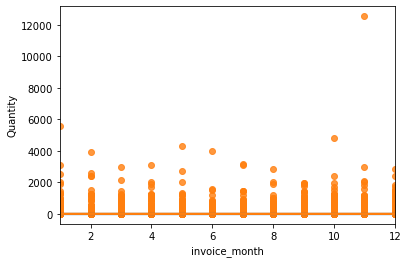

In [151]:
# df_new0[df_new0.Quantity<=max(df_new0.Quantity)]
# df_new0[(np.abs(stats.zscore(df_new0.Quantity)) < 3)] #530818; # df_new0 #531283
print(df_new0.Quantity.describe().take([3,7]))
df_quantity_sans_outliers = df_new0[(np.abs(stats.zscore(df_new0.Quantity)) < .1)]
print(df_quantity_sans_outliers.Quantity.describe().take([3,7]))
print(sns.regplot(x='invoice_month', y='Quantity', data=df_quantity_sans_outliers))
# A different scatterplot is described below cell 149.
sns.regplot(x='invoice_month', y='Quantity', data=df_new0)

In [140]:

df_new0['invoice_month_str'] = df_new0.invoice_month.astype(str)
print(df_new0.invoice_month_str.value_counts())
print('\n____________________\nREGRESSION SUMMARY:\n____________________\n', 'Quantity~C(invoice_month_str, Treatment(reference="11"))', smf.ols(formula = 'Quantity~C(invoice_month_str, Treatment(reference="11"))', data=df_new0).fit().summary())


11    82133
12    66048
10    58629
9     48962
7     38466
5     36044
6     35793
3     35609
8     34345
1     34103
4     28957
2     26961
Name: invoice_month_str, dtype: int64

____________________
REGRESSION SUMMARY:
____________________
 Quantity~C(invoice_month_str, Treatment(reference="11"))                             OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     24.36
Date:                Mon, 24 May 2021   Prob (F-statistic):           5.04e-51
Time:                        20:40:37   Log-Likelihood:            -2.7321e+06
No. Observations:              526050   AIC:                         5.464e+06
Df Residuals:                  526038   BIC:                         5.464e+06
Df Model:                          11                            

## Interpretation for regression 2 (Quantity~invoice_month):
#### The following regression is kind of boring, so I'm not analyzing it as my primary example. Essentially, it's saying that items purchased in a higher quantity (in a single transaction) are, on average, cheaper than items purchased in smaller quantities. An example of this could be purchasing beers versus diamond rings. Beers are cheaper and more likely to be purchased in multiple-quantities than are diamond rings. Typically, individual retail shoppers will purchase one diamond ring in one trip to the store for some special occassion, like a wedding. I find this regression a little dull because it's SO intuitive. Thus, I'm analyzing it, but not giving it the full attention of this lab. The p-value is specifically .005, which is lower than the threshold of .05, so we have a significant relationship.
#### - **Specific interpretation**: for each **_dollar_** increase in the **_unit price_**, on average, the **_quantity of items per purchase/transaction_** is **_statistically significantly (p<.000) lower_** by **_0.0111 (coefficient=-0.0111)_**.
#### - *Regression summary printed below...*

In [141]:
print('\n____________________\nREGRESSION SUMMARY:\n____________________\n', 'UnitPrice~Quantity', smf.ols(formula = 'UnitPrice~Quantity', data=df_new0).fit().summary()) 


____________________
REGRESSION SUMMARY:
____________________
 UnitPrice~Quantity                             OLS Regression Results                            
Dep. Variable:              UnitPrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     94.64
Date:                Mon, 24 May 2021   Prob (F-statistic):           2.29e-22
Time:                        20:40:37   Log-Likelihood:            -2.6323e+06
No. Observations:              526050   AIC:                         5.265e+06
Df Residuals:                  526048   BIC:                         5.265e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

<AxesSubplot:xlabel='Quantity', ylabel='UnitPrice'>

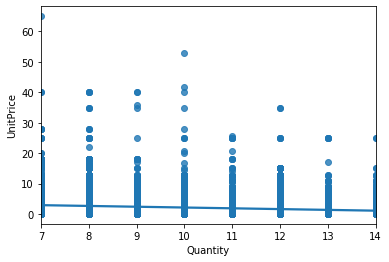

In [150]:
# df_price_sans_outliers = df_quantity_sans_outliers[(np.abs(stats.zscore(df_quantity_sans_outliers.UnitPrice)) < 45)]
# A different scatterplot is described below cell 149.
sns.regplot(x='Quantity', y='UnitPrice', data=df_quantity_sans_outliers)

## Interpretation for EXTRA regression (UnitPrice~n_words_description):
### Also interesting: the more words in the description, the cheaper the unit price. I wonder if that's because cheap products try to compensate for their cheapness by being overly verbose with their descriptions, hoping it might better lure customers?

In [143]:
# p_value = 0.077 
# comparison factor: cotton
# There is a marginally significant relationship between primary fabric type and price of clothing item. The fabric rayon has, on average, a $79.24 (coefficient of 79.2405) higher price than does cotton (marginally significant with p=.077).
# for each $79.24 increase in 

In [145]:
print('\n', 'UnitPrice~n_words_description', smf.ols(formula = 'UnitPrice~n_words_description', data=df_new0).fit().summary())


 UnitPrice~n_words_description                             OLS Regression Results                            
Dep. Variable:              UnitPrice   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1058.
Date:                Mon, 24 May 2021   Prob (F-statistic):          9.18e-232
Time:                        20:43:41   Log-Likelihood:            -2.6318e+06
No. Observations:              526050   AIC:                         5.264e+06
Df Residuals:                  526048   BIC:                         5.264e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
In

<AxesSubplot:xlabel='UnitPrice', ylabel='n_words_description'>

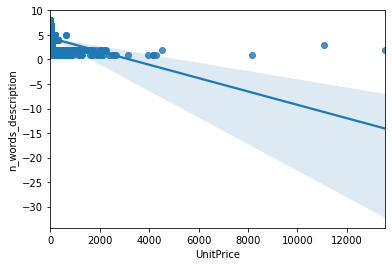

In [152]:
sns.regplot(x='UnitPrice', y='n_words_description', data=df_new0)
# Scatterplot described below under Q4!

# <b style="color: darkblue">4. Plot two variables, either as a scatter plot or boxplot; add in trend/regression lines; and explain your results.</b>

## Scatterplots are rendered and described above, in the following cells... 
### Based on the above scatterplot, most items in the data set had word decriptions of 0 to 5 words and were priced in the range of $0-$4000. There were certain outliers found at unit prices 8000+, 10000+, 12000+. These items were probably highly prestigious and luxurious items. These had slightly fewers words in their descriptions, possibly because they're already high-end and don't need extra eloquent verbiage to sell (but that's just one theoretical possibility)! The regression line was a little misleading as the line was continuous throughout negative numbers for n_words_description, which is not realistic or feasible. All in all, at face value, it looks like there's a pretty clear negative relationship between unit price and word count of the given item's description.